In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import h5py 
import tensorflow as tf
from tensorflow.python.framework import ops
from tf_utils import load_dataset, random_mini_batches, convert_to_one_hot, predict

%matplotlib inline
np.random.seed(1)

X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()


In [9]:
#Flattening the training and test Images

X_train_flat = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_test_flat = X_test_orig.reshape(X_test_orig.shape[0], -1).T

# Normalize these image vectors

X_train_flat = X_train_flat/255
X_test_flat = X_test_flat/255

# Convert labels to One Hot encoding

Y_train = convert_to_one_hot(Y_train_orig, 6)
Y_test  = convert_to_one_hot(Y_test_orig, 6)


1. Creating Placeholders for X and Y so that later on training data can be passed

In [30]:
def create_placeholders(n_x,n_y):
    X = tf.placeholder(tf.float32, [n_x, None], name = "X")
    Y = tf.placeholder(tf.float32, [n_y, None], name = "Y")
    
    return X, Y

2. Initialize Parameters using Xavier for Weights and Zero for Biases

In [31]:
def initialize_parameters():
    
    tf.set_random_seed(1)
    
    W1 = tf.get_variable("W1", [25, 12288], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b1 = tf.get_variable("b1", [25,1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [12, 25], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b2 = tf.get_variable("b2", [12,1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [6, 12], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b3 = tf.get_variable("b3", [6,1], initializer = tf.zeros_initializer())
    
    parameters = {"W1":W1,
                 "b1" :b1,
                 "W2" :W2,
                 "b2" :b2,
                 "W3" :W3,
                 "b3" :b3}
    
    return parameters
    

3. Forward Prop using tf.add, tf.matmul, tf.nn.relu

In [32]:
def forward_propagation(X, parameters):
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    Z1 = tf.add(tf.matmul(W1,X) ,b1)
    A1 = tf.nn.relu(Z1)
    Z2 = tf.add(tf.matmul(W2,A1) ,b2)
    A2 = tf.nn.relu(Z2)
    Z3 = tf.add(tf.matmul(W3,A2), b3)
    
    return Z3

    4. Compute cost using tf.rreduce_mean(tf.nn.softmax_cross_entropy_with_logits())

In [33]:
def compute_cost(Z3, Y):
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels))
    
    return cost

4. Back Prop and parameter Update 

After we compute cost function, we will create an optimizer object and when called this will perform an optimization on the given cost with chosen method and learning rate

optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(cost)

To make the optimization using this optimizer object, you would:

_ , c = sess.run([optimizer, cost], feed_dict = {X:minibatch_X, Y: minibatch_Y})

5. Building the model 

In [34]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.001, num_epochs = 1000, minibatch_size = 32, print_cost = True):
    
    ops.reset_default_graph()
    tf.set_random_seed(1)
    seed = 3
    
    (n_x, m) = X_train.shape
    n_y = Y_train.shape[0]
    
    costs = []
    
    #Create Placeholders
    X,Y = create_placeholders(n_x, n_y)
    
    #Initialize Params
    parameters = initialize_parameters()
    
    #Forward pass
    Z3 = forward_propagation(X, parameters)
    
    #Compute cost
    cost = compute_cost(Z3, Y)
    
    #Optimizer object
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    
    #Initialize all variables
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        
        for epoch in range(num_epochs):
            
            epoch_cost = 0
            
            #Creating Minibatches
            num_minibatches = int(m/minibatch_size)
            seed = seed+1
            minibatches = random_mini_batches(X_train, Y_train,minibatch_size, seed)
            
            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                _, minibatch_cost= sess.run([optimizer, cost], feed_dict = {X: minibatch_X, Y: minibatch_Y})
                epoch_cost += minibatch_cost/num_minibatches
            
            if epoch % 100 == 0:
                print("Cost after every epoch %i: %f" %(epoch, epoch_cost))
                costs.append(epoch_cost)
                
                
        
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.show()
        
        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

        
           
            
    

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Cost after every epoch 0: 1.951921
Cost after every epoch 100: 0.906226
Cost after every epoch 200: 0.590555
Cost after every epoch 300: 0.375800
Cost after every epoch 400: 0.228579
Cost after every epoch 500: 0.231701
Cost after every epoch 600: 0.080684
Cost after every epoch 700: 0.055372
Cost after every epoch 800: 0.547076
Cost after every epoch 900: 0.379035


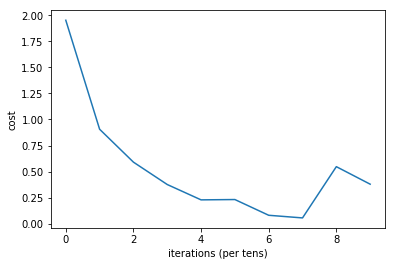

Parameters have been trained!
Train Accuracy: 0.94166666
Test Accuracy: 0.73333335


In [35]:
params = model(X_train_flat, Y_train, X_test_flat, Y_test)